The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


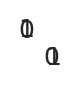

In [28]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, HLAS, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass
from src.datasets import NNAlignDatasetEFSinglePass

In [43]:
df = pd.read_csv('../data/mhc1_el_sub10k/sample_no_u.csv').sample(10, random_state=0)
df

,Unnamed: 0,Sequence,target,HLA,pseudoseq,fold,len,flag
11841,11841,LLMAVAAPSRAR,0.0,HLA-B57:01,LLLLLMRARGSG,1,12,False
19385,19385,LLLVVVHVI,0.0,HLA-B39:06,LLQLLLHVINSL,1,9,False
16311,16311,NGFEGTDM,0.0,HLA-B35:02,SELNGFTDMKDM,1,8,False
19379,19379,NRYLDFSSK,0.0,HLA-C07:02,WISNRYSSKEVK,1,9,False
36752,36753,SVDIRTMSSRDLL,0.0,HLA-B15:01,AALSVDDLLNAL,3,13,False
31901,31902,MQAHITRA,0.0,HLA-C12:03,LCTMQATRALHN,3,8,False
32425,32426,LSFCHICFELNIE,0.0,HLA-C07:01,KETLSFNIEGVP,3,13,False
12363,12363,SKQRRSRRK,0.0,HLA-C07:02,LALSKQRRKKAN,1,9,False
38721,38722,IKVSKAAADLMT,0.0,HLA-C03:03,LCRIKVLMTYCD,3,12,False
43820,43821,SVLISLKQA,0.0,HLA-B07:02,RMRSVLKQAPLV,4,9,False


In [32]:
from torch.utils.data import SequentialSampler
dataset = NNAlignDatasetEFSinglePass(df, max_len=13, window_size=9, indel=True, seq_col = 'Sequence')
loader = dataset.get_dataloader(1024, SequentialSampler)

In [42]:
dataset.x_mask
df['Sequence']

11841    LLMAVAAPSRAR
19602     EYTDGTFRIPR
45519    SPDGSLQTGKPS
25747       IDHNGFHHL
42642     NKSTSSAMSGS
31902        MQAHITRA
30346       DEGKLLIGF
12363       SKQRRSRRK
32490        MVDVPGHG
26128        VSGPLAFA
Name: Sequence, dtype: object

In [87]:
def generate_motif(sequence, best_index, window_size, max_len):
    """
    Generate the motif from the sequence based on the best index.
    Handles both direct extraction, insertions, and deletions.

    :param sequence: The original sequence stored in the DataFrame.
    :param best_index: The index indicating where to extract or modify the sequence.
    :param window_size: The window size for the motif.
    :param max_len: The maximum length considered for direct extraction.
    :return: The motif string.
    """
    # Direct extraction from the sequence
    if best_index < max_len - window_size + 1:
        return sequence[best_index:best_index + window_size]
    
    # For insertions or deletions
    else:
        seq_len = len(sequence)
        # Adjust best_index for 0-based indexing
        adjusted_index = best_index - (max_len - window_size + 1)
        print(adjusted_index)
        motif = ''
        print(adjusted_index)
        # Handling insertions
        if seq_len < window_size:
            insertion_position = adjusted_index
            motif = sequence[:insertion_position] + '-' + sequence[insertion_position:]
            motif = motif[:window_size]  # Ensure motif is not longer than window size
        
        # Handling deletions
        elif seq_len > window_size:
            deletion_position = adjusted_index
            del_len = seq_len - window_size
            motif = sequence[:deletion_position] + sequence[deletion_position + del_len:]
            # If the sequence with deletion is longer than window_size, trim it to the window_size
            if len(motif) > window_size:
                motif = motif[:window_size]
                
        return motif

# Example usage
sequence = "ARNFELPH"  # Example sequence
best_index = 5  # Example index indicating a deletion
window_size = 9
max_len = 13  # Assuming max_len includes the padded length

# Generate the motif
motif = generate_motif(sequence, best_index, window_size, max_len)
print(f"Generated motif: {motif}")
       

0
0
Generated motif: -ARNFELPH
